In [7]:
# SAR-to-EO CycleGAN Results Visualization
import os
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import yaml
from tqdm import tqdm
import pandas as pd

from utils.dataset import Sen12MSDataset, create_data_loader
from utils.metrics import calculate_ndvi, evaluate_model
from models.cyclegan import CycleGANModel

plt.style.use('seaborn-v0_8')
%matplotlib inline

# Load configuration
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Available configurations:", list(config['band_configs'].keys()))

Available configurations: ['rgb', 'nir_swir', 'rgb_nir']


In [8]:
def load_and_test_model(config_name):
    """Load trained model and generate test results"""
    config['current_config'] = config_name
    
    # Create test dataset
    band_config = config['band_configs'][config_name]
    target_bands = band_config['bands']
    
    dataset = Sen12MSDataset(
        config['data']['sar_dir'], 
        config['data']['eo_dir'], 
        target_bands
    )
    
    # Use test split
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    test_size = dataset_size - train_size
    
    _, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    test_loader = create_data_loader(test_dataset, batch_size=1, shuffle=False)
    
    # Load model
    model = CycleGANModel(config)
    checkpoint_dir = f"../checkpoints/{config_name}"
    model.load_networks('final', checkpoint_dir)
    model.eval_mode()
    
    return model, test_loader

In [9]:
def create_comparison_plot(config_name, num_samples=3):
    """Create detailed comparison plots"""
    model, test_loader = load_and_test_model(config_name)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_samples:
                break
                
            model.set_input(batch)
            model.forward()
            
            # Get images
            sar_img = batch['sar'][0].cpu().numpy()
            generated_eo = model.fake_B[0].cpu().numpy()
            real_eo = batch['eo'][0].cpu().numpy()
            
            # SAR VV
            axes[i, 0].imshow((sar_img[0] + 1) / 2, cmap='gray')
            axes[i, 0].set_title(f'SAR VV - Sample {i+1}')
            axes[i, 0].axis('off')
            
            # SAR VH
            axes[i, 1].imshow((sar_img[1] + 1) / 2, cmap='gray')
            axes[i, 1].set_title(f'SAR VH - Sample {i+1}')
            axes[i, 1].axis('off')
            
            # Generated EO
            if config_name in ['rgb', 'rgb_nir']:
                rgb_gen = generated_eo[:3].transpose(1, 2, 0)
                rgb_gen = np.clip((rgb_gen + 1) / 2, 0, 1)
                axes[i, 2].imshow(rgb_gen)
            else:
                axes[i, 2].imshow((generated_eo[0] + 1) / 2, cmap='RdYlGn')
            axes[i, 2].set_title(f'Generated EO - Sample {i+1}')
            axes[i, 2].axis('off')
            
            # Real EO
            if config_name in ['rgb', 'rgb_nir']:
                rgb_real = real_eo[:3].transpose(1, 2, 0)
                rgb_real = np.clip((rgb_real + 1) / 2, 0, 1)
                axes[i, 3].imshow(rgb_real)
            else:
                axes[i, 3].imshow((real_eo[0] + 1) / 2, cmap='RdYlGn')
            axes[i, 3].set_title(f'Real EO - Sample {i+1}')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'{config_name.upper()} Configuration Results', fontsize=16, y=1.02)
    plt.show()


In [10]:
def analyze_spectral_differences():
    """Analyze spectral differences between configurations"""
    
    metrics_all = {}
    
    for config_name in ['rgb', 'nir_swir', 'rgb_nir']:
        model, test_loader = load_and_test_model(config_name)
        metrics = evaluate_model(model, test_loader, config_name)
        metrics_all[config_name] = metrics
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    metrics_to_plot = ['psnr', 'ssim', 'mae', 'rmse']
    titles = ['PSNR (dB)', 'SSIM', 'MAE', 'RMSE']
    
    for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[idx // 2, idx % 2]
        
        configs = list(metrics_all.keys())
        values = [metrics_all[config][metric] for config in configs]
        errors = [metrics_all[config][f'{metric}_std'] for config in configs]
        
        bars = ax.bar(configs, values, yerr=errors, capsize=5, 
                     color=['skyblue', 'lightcoral', 'lightgreen'])
        ax.set_title(title)
        ax.set_ylabel(title)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(errors)/10,
                   f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.suptitle('Performance Comparison Across Configurations', fontsize=16, y=1.02)
    plt.show()
    
    return metrics_all

In [11]:
def create_metrics_table(metrics_comparison):
    """Create a formatted metrics comparison table"""
    
    # Prepare data for table
    table_data = []
    
    for config in ['rgb', 'nir_swir', 'rgb_nir']:
        metrics = metrics_comparison[config]
        row = {
            'Configuration': config.upper(),
            'PSNR (dB)': f"{metrics['psnr']:.3f} ± {metrics['psnr_std']:.3f}",
            'SSIM': f"{metrics['ssim']:.3f} ± {metrics['ssim_std']:.3f}",
            'MAE': f"{metrics['mae']:.3f} ± {metrics['mae_std']:.3f}",
            'RMSE': f"{metrics['rmse']:.3f} ± {metrics['rmse_std']:.3f}"
        }
        
        if metrics['ndvi_corr'] > 0:
            row['NDVI Corr'] = f"{metrics['ndvi_corr']:.3f} ± {metrics['ndvi_corr_std']:.3f}"
        else:
            row['NDVI Corr'] = 'N/A'
            
        table_data.append(row)
    
    df = pd.DataFrame(table_data)
    
    # Display styled table
    print("Performance Metrics Comparison")
    print("=" * 80)
    print(df.to_string(index=False))
    print("=" * 80)
    
    return df

hi
0
Found 0 valid file pairs
Networks loaded from epoch final


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


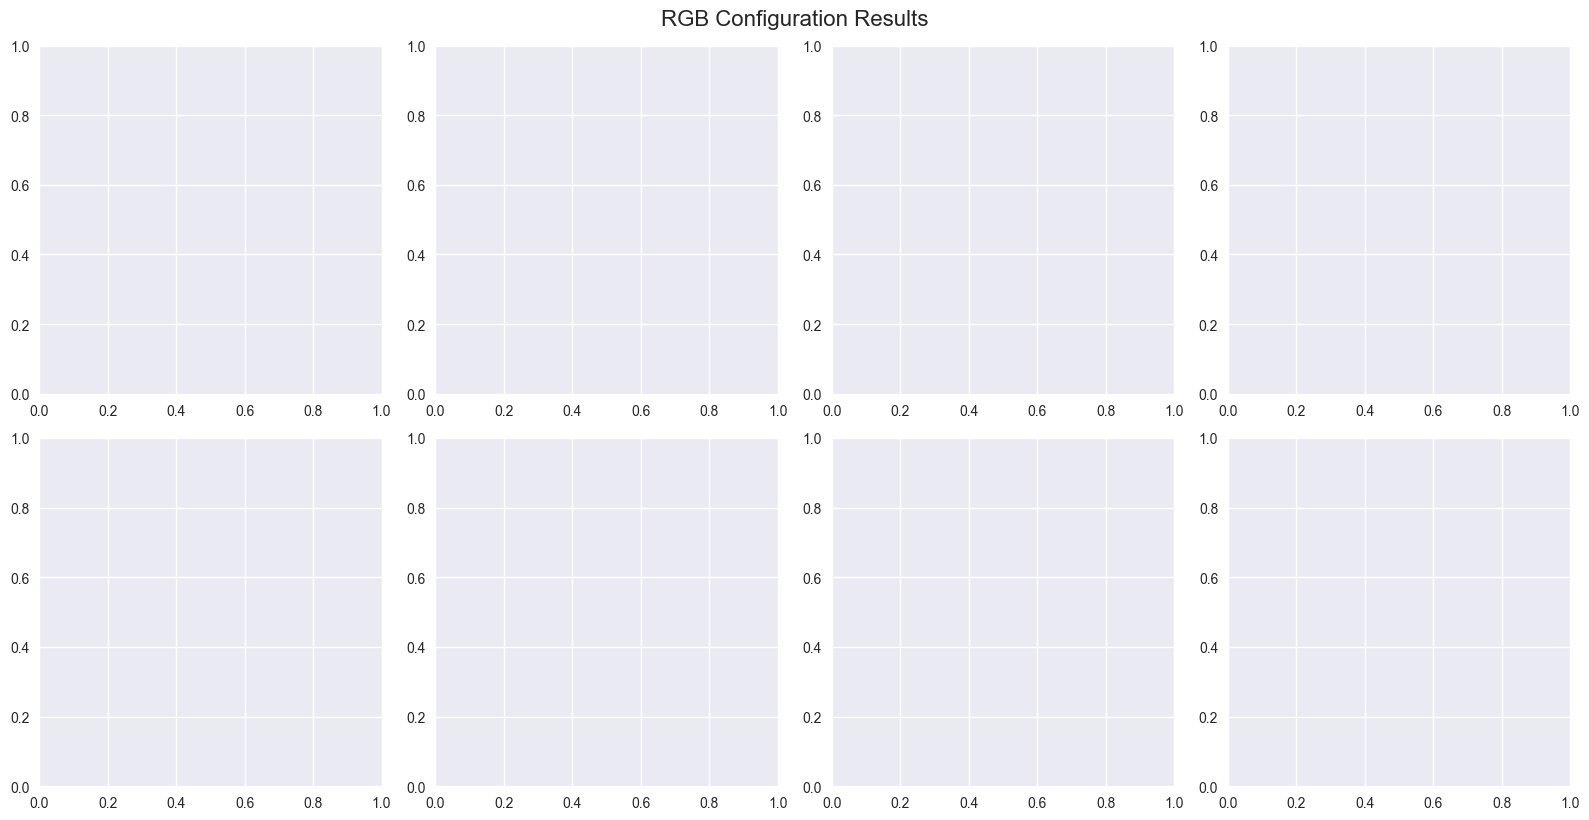

hi
0
Found 0 valid file pairs


FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/nir_swir\\net_G_A_epoch_final.pth'

In [12]:
# Generate comparison plots for all configurations
for config_name in ['rgb', 'nir_swir', 'rgb_nir']:
    create_comparison_plot(config_name, num_samples=2)

# Analyze and compare metrics
metrics_comparison = analyze_spectral_differences()

# Create metrics table
results_table = create_metrics_table(metrics_comparison)